# ***Libraries & Tools***

In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import random
import shutil
import networkx as nx
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from collections import defaultdict, Counter
from scipy import sparse
from pathlib import Path

# ***Loading the Nodes***

In [2]:
df = pd.read_parquet("cs_papers_wo_embeddings.parquet")
df['categories'] = df['categories'].apply(lambda x: x.replace(', ', ''))

In [3]:
df.head(10)

,id,authors,title,categories,abstract,update_date,degree,num_citations,num_references
0,0704.0046,"I. Csiszar, F. Hiai, D. Petz",A limit relation for entropy and channel capac...,quant-ph cs.IT math.IT,"In a quantum mechanical model, Diosi, Feldma...",2009-11-13,1,1,0
1,0704.0062,"Rastislav \v{S}r\'amek, Bro\v{n}a Brejov\'a, T...",On-line Viterbi Algorithm and Its Relationship...,cs.DS,"In this paper, we introduce the on-line Vite...",2010-01-25,2,2,0
2,0704.0098,"Jack Raymond, David Saad",Sparsely-spread CDMA - a statistical mechanics...,cs.IT math.IT,"Sparse Code Division Multiple Access (CDMA),...",2009-11-13,1,1,0
3,0704.0108,Sergey Gubin,Reducing SAT to 2-SAT,cs.CC,Description of a polynomial time reduction o...,2007-05-23,5,1,4
4,0704.0213,Ketan D. Mulmuley Hariharan Narayanan,Geometric Complexity Theory V: On deciding non...,cs.CC,This article has been withdrawn because it h...,2012-09-28,1,1,0
5,0704.0218,Yuri Pritykin,On Almost Periodicity Criteria for Morphic Seq...,cs.DM cs.LO,In some particular cases we give criteria fo...,2007-05-23,2,0,2
6,0704.0229,Ketan D. Mulmuley,Geometric Complexity Theory VI: the flip via s...,cs.CC,This article belongs to a series on geometri...,2009-01-22,4,4,0
7,0704.0304,Carlos Gershenson,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,2013-04-05,8,8,0
8,0704.0309,Guohun Zhu,The Complexity of HCP in Digraps with Degree B...,cs.CC cs.DM,The Hamiltonian cycle problem (HCP) in digra...,2011-11-09,2,2,0
9,0704.0540,"Jinhua Jiang, Xin Yan",On the Achievable Rate Regions for Interferenc...,cs.IT math.IT,The interference channel with degraded messa...,2007-07-13,3,1,2


In [6]:
df.shape

(88281, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88281 entries, 0 to 88280
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              88281 non-null  object
 1   authors         88281 non-null  object
 2   title           88281 non-null  object
 3   categories      88281 non-null  object
 4   abstract        88281 non-null  object
 5   update_date     88281 non-null  object
 6   degree          88281 non-null  int64 
 7   num_citations   88281 non-null  int64 
 8   num_references  88281 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.1+ MB


In [6]:
df.isnull().sum()

id                0
authors           0
title             0
categories        0
abstract          0
update_date       0
degree            0
num_citations     0
num_references    0
dtype: int64

## Degree distribution 

In [ ]:
df.drop('Binned', axis=1, inplace=True)

In [76]:
df['degree'].value_counts().sort_index()

degree
1       12750
2        8435
3        5929
4        4338
5        3349
        ...  
1191        1
1252        1
1473        1
3970        1
4986        1
Name: count, Length: 241, dtype: int64

Bins: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, np.int64(4987)]
Bin Counts:
 Binned
[1, 2)          12750
[2, 4)          14364
[4, 8)          12535
[8, 16)          8367
[16, 32)         3263
[32, 64)          897
[64, 128)         275
[128, 256)         95
[256, 512)         29
[512, 1024)        13
[1024, 2048)        6
[2048, 4096)        1
[4096, 4987)        1
Name: count, dtype: int64


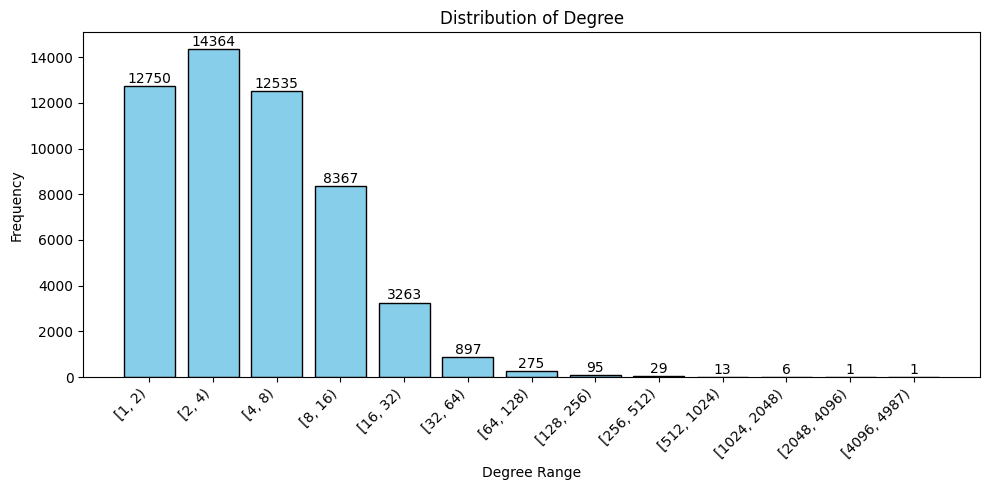

In [77]:
# Define power-of-2 bins
max_value = df['degree'].max()
bins = [2**i for i in range(int(np.log2(max_value)) + 2)]  # Define bins up to the next power of 2
bins[-1] = max_value + 1  # Ensure the last bin covers the max value

# Bin the "Degree" column
df['Binned'] = pd.cut(df['degree'], bins=bins, right=False)

# Count occurrences in each bin
bin_counts = df['Binned'].value_counts(sort=False)

# Print results
print("Bins:", bins)
print("Bin Counts:\n", bin_counts)

plt.figure(figsize=(10, 5))
bin_labels = [f"[{int(b.left)}, {int(b.right)})" for b in bin_counts.index]
bars = plt.bar(bin_labels, bin_counts.values, color='skyblue', edgecolor='black')

# Add counts above bars
for bar, count in zip(bars, bin_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Position text
             str(count), ha='center', va='bottom', fontsize=10)

# Customize plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Degree Range")
plt.ylabel("Frequency")
plt.title("Distribution of Degree")
plt.tight_layout()

# Save plot as SVG
plt.savefig("graph-v2/Degree_Distribution-v2.svg", format="svg")
plt.savefig("graph-v2/Degree_Distribution-v2.png", format="png")
plt.savefig("graph-v2/Degree_Distribution-v2.jpg", format="jpg")



# Show plot
plt.show()

## Dataframe preparation

In [7]:
df['id'].duplicated().any()

np.False_

In [8]:
print(df[df['id'].duplicated(keep=False)])

Empty DataFrame
Columns: [id, authors, title, categories, abstract, update_date, degree, num_citations, num_references]
Index: []


In [4]:
# Find the abstracts that have been withdrawn
withdrawn_paper_indices = []
for index, row in df.iterrows():
    if "withdrawn" in row['abstract']:
        withdrawn_paper_indices.append(index)

print(f'Withdrawn abstract indices: {withdrawn_paper_indices}')

Withdrawn abstract indices: [4, 296, 303, 459, 604, 684, 1153, 1624, 1710, 2060, 2321, 4217, 9960, 22804, 34682, 52388, 67922, 87239, 88135]


In [8]:
for idx in withdrawn_paper_indices:
    #print(df.iloc[idx]['title'] + ". " + df.iloc[idx]['abstract'])
    print(df.iloc[idx]['abstract'])

  This article has been withdrawn because it has been merged with the earlier article GCT3 (arXiv: CS/0501076 [cs.CC]) in the series. The merged article is now available as:   Geometric Complexity Theory III: on deciding nonvanishing of a Littlewood-Richardson Coefficient, Journal of Algebraic Combinatorics, vol. 36, issue 1, 2012, pp. 103-110. (Authors: Ketan Mulmuley, Hari Narayanan and Milind Sohoni)   The new article in this GCT5 slot in the series is:   Geometric Complexity Theory V: Equivalence between blackbox derandomization of polynomial identity testing and derandomization of Noether's Normalization Lemma, in the Proceedings of FOCS 2012 (abstract), arXiv:1209.5993 [cs.CC] (full version) (Author: Ketan Mulmuley) 
  This paper has been withdrawn 
  This paper has been withdrawn 
  This paper has been withdrawn 
  This paper has been withdrawn by the corresponding author because the newest version is now published in Journal of Discrete Algorithms. 
  This paper has been withdr

In [5]:
# Not all papers are truly withdrawn. Select those that are truly withdrawn
final_withdrawn_paper_indices = [4, 296, 303, 459, 604, 684, 1153, 1624, 1710, 2060, 2321, 9960, 67922, 87239, 88135] #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 17, 18]
withdrawn_paper_ids = [df.iloc[idx]['id'] for idx in final_withdrawn_paper_indices]

In [6]:
withdrawn_paper_ids

['0704.0213',
 '0709.3334',
 '0709.4420',
 '0712.0392',
 '0802.0314',
 '0802.3572',
 '0808.0549',
 '0901.2082',
 '0902.0189',
 '0905.0233',
 '0907.1413',
 '1206.5054',
 '1805.02682',
 'cs/0602074',
 'quant-ph/0312174']

***NOTE***: Run the below code only when you want to create a small graph

In [7]:
valid_categories = {'cs.LG', 'cs.CV', 'cs.IT', 'math.IT', 'stat.ML', 'cs.AI', 'cs.CL'}

indices_for_nodes_to_be_removed = []
ids_for_nodes_to_be_removed = []

for idx, row in df.iterrows():
    if not set(row['categories'].split()).intersection(valid_categories): #if not set(row['categories'].split()).issubset(valid_categories):
        indices_for_nodes_to_be_removed.append(idx)
        ids_for_nodes_to_be_removed.append(row['id'])

In [8]:
# Be cautious with this
withdrawn_paper_ids = list(set(withdrawn_paper_ids                     + ids_for_nodes_to_be_removed))
final_withdrawn_paper_indices = list(set(final_withdrawn_paper_indices + indices_for_nodes_to_be_removed))

In [9]:
print(len(indices_for_nodes_to_be_removed))
print(len(ids_for_nodes_to_be_removed))

print(len(withdrawn_paper_ids))
print(len(final_withdrawn_paper_indices))

33438
33438
33447
33447


In [46]:
# Create a mapping between the id of a node and its index 
orig_new_id_mapping = {}
for idx, row in df.iterrows():
    orig_new_id_mapping[row['id']] = str(idx)

In [ ]:
orig_new_id_mapping

### The python code below will create a categories file based on the original but its structure will be: nodeID    node_label1 node_label2 ....

In [2]:
# In case where a node doesn't have a label
categories_path = '/home/georgematlis/Content-Aware Node Embeddings (Master Thesis)/CANE/datasets/cora'

with open(f'{categories_path}/group.txt', 'r') as infile, open(f'{categories_path}/group-v2.txt', 'w') as out:
    for line in infile:
        line = line.strip()  # Remove any surrounding whitespace
        if line.isdigit():   # Check if the line contains only a digit
            out.write(line + '\n')
        else:
            out.write(str(0) + '\n')


In [79]:
output_filename = "graph-v2/group-v2.txt"

with open("graph-v2/group.txt", "r") as infile, open(output_filename, "w") as outfile:
    for node_id, line in enumerate(infile):
        labels = line.strip().split(",")  # Split labels by comma
        outfile.write(f"{node_id} {' '.join(labels)}\n")

print(f"File '{output_filename}' created successfully.")

File 'graph-v2/group-v2.txt' created successfully.


### The python code below concatenates the keywords with the specific categories

In [ ]:
def concatenate_files(file1, file2, output_file):
    with open(file1, 'r', encoding='utf-8') as f1, open(file2, 'r', encoding='utf-8') as f2, open(output_file, 'w', encoding='utf-8') as out:
        for line1, line2 in zip(f1, f2):
            out.write(f"{line1.strip()} {line2.strip()}\n")

# Example usage:
concatenate_files("graph-v2/data.txt", "graph-v2/Specific_Categories.txt", "graph-v2/data-v2.txt")

## Categories Dictionaries

In [10]:
specific_categories_dict = {
    'adap-org':'Adaptation and Self-Organizing Systems',

    'astro-ph':'Astrophysics',
    'astro-ph.CO':'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP':'Earth and Planetary Astrophysics',
    'astro-ph.GA':'Astrophysics of Galaxies',
    'astro-ph.HE':'High Energy Astrophysical Phenomena',
    'astro-ph.IM':'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR':'Solar and Stellar Astrophysics',

    'chao-dyn':'Chaotic Dynamics',
    'cmp-lg':'Computation and Language',

    'cond-mat':'Condensed Matter',
    'cond-mat.dis-nn':'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall':'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci':'Materials Science',
    'cond-mat.other':'Other Condensed Matter',
    'cond-mat.quant-gas':'Quantum Gases',
    'cond-mat.soft':'Soft Condensed Matter',
    'cond-mat.stat-mech':'Statistical Mechanics',
    'cond-mat.str-el':'Strongly Correlated Electrons',
    'cond-mat.supr-con':'Superconductivity',

    'cs.AI':'Artificial Intelligence',
    'cs.AR':'Hardware Architecture',
    'cs.CC':'Computational Complexity',
    'cs.CE':'Computational Engineering, Finance, and Science',
    'cs.CG':'Computational Geometry',
    'cs.CL':'Computation and Language',
    'cs.CR':'Cryptography and Security',
    'cs.CV':'Computer Vision and Pattern Recognition',
    'cs.CY':'Computers and Society',
    'cs.DB':'Databases',
    'cs.DC':'Distributed, Parallel, and Cluster Computing',
    'cs.DL':'Digital Libraries',
    'cs.DM':'Discrete Mathematics',
    'cs.DS':'Data Structures and Algorithms',
    'cs.ET':'Emerging Technologies',
    'cs.FL':'Formal Languages and Automata Theory',
    'cs.GL':'General Literature',
    'cs.GR':'Graphics',
    'cs.GT':'Computer Science and Game Theory',
    'cs.HC':'Human-Computer Interaction',
    'cs.IR':'Information Retrieval',
    'cs.IT':'Information Theory',
    'cs.LG':'Machine Learning',
    'cs.LO':'Logic in Computer Science',
    'cs.MA':'Multiagent Systems',
    'cs.MM':'Multimedia',
    'cs.MS':'Mathematical Software',
    'cs.NA':'Numerical Analysis',
    'cs.NE':'Neural and Evolutionary Computing',
    'cs.NI':'Networking and Internet Architecture',
    'cs.OH':'Other Computer Science',
    'cs.OS':'Operating Systems',
    'cs.PF':'Performance',
    'cs.PL':'Programming Languages',
    'cs.RO':'Robotics',
    'cs.SC':'Symbolic Computation',
    'cs.SD':'Sound',
    'cs.SE':'Software Engineering',
    'cs.SI':'Social and Information Networks',
    'cs.SY':'Systems and Control',

    'econ.EM':'Econometrics',
    'econ.GN':'General Economics',
    'econ.TH':'Theoretical Economics',

    'eess.AS':'Audio and Speech Processing',
    'eess.IV':'Image and Video Processing',
    'eess.SP':'Signal Processing',
    'eess.SY':'Systems and Control',

    'gr-qc':'General Relativity and Quantum Cosmology',
    'hep-ex':'High Energy Physics - Experiment',
    'hep-lat':'High Energy Physics - Lattice',
    'hep-ph':'High Energy Physics - Phenomenology',
    'hep-th':'High Energy Physics - Theory',
    'math-ph':'Mathematical Physics',

    'math.AC':'Commutative Algebra',
    'math.AG':'Algebraic Geometry',
    'math.AP':'Analysis of PDEs',
    'math.AT':'Algebraic Topology',
    'math.CA':'Classical Analysis and ODEs',
    'math.CO':'Combinatorics',
    'math.CT':'Category Theory',
    'math.CV':'Complex Variables',
    'math.DG':'Differential Geometry',
    'math.DS':'Dynamical Systems',
    'math.FA':'Functional Analysis',
    'math.GM':'General Mathematics',
    'math.GN':'General Topology',
    'math.GR':'Group Theory',
    'math.GT':'Geometric Topology',
    'math.HO':'History and Overview',
    'math.IT':'Information Theory',
    'math.KT':'K-Theory and Homology',
    'math.LO':'Logic',
    'math.MG':'Metric Geometry',
    'math.MP':'Mathematical Physics',
    'math.NA':'Numerical Analysis',
    'math.NT':'Number Theory',
    'math.OA':'Operator Algebras',
    'math.OC':'Optimization and Control',
    'math.PR':'Probability',
    'math.QA':'Quantum Algebra',
    'math.RA':'Rings and Algebras',
    'math.RT':'Representation Theory',
    'math.SG':'Symplectic Geometry',
    'math.SP':'Spectral Theory',
    'math.ST':'Statistics Theory',

    'nlin.AO':'Adaptation and Self-Organizing Systems',
    'nlin.CD':'Chaotic Dynamics',
    'nlin.CG':'Cellular Automata and Lattice Gases',
    'nlin.PS':'Pattern Formation and Solitons',
    'nlin.SI':'Exactly Solvable and Integrable Systems',

    'nucl-ex':'Nuclear Experiment',
    'nucl-th':'Nuclear Theory',

    'physics.acc-ph':'Accelerator Physics',
    'physics.ao-ph':'Atmospheric and Oceanic Physics',
    'physics.app-ph':'Applied Physics',
    'physics.atm-clus':'Atomic and Molecular Clusters',
    'physics.atom-ph':'Atomic Physics',
    'physics.bio-ph':'Biological Physics',
    'physics.chem-ph':'Chemical Physics',
    'physics.class-ph':'Classical Physics',
    'physics.comp-ph':'Computational Physics',
    'physics.data-an':'Data Analysis, Statistics and Probability',
    'physics.ed-ph':'Physics Education',
    'physics.flu-dyn':'Fluid Dynamics',
    'physics.gen-ph':'General Physics',
    'physics.geo-ph':'Geophysics',
    'physics.hist-ph':'History and Philosophy of Physics',
    'physics.ins-det':'Instrumentation and Detectors',
    'physics.med-ph':'Medical Physics',
    'physics.optics':'Optics',
    'physics.plasm-ph':'Plasma Physics',
    'physics.pop-ph':'Popular Physics',
    'physics.soc-ph':'Physics and Society',
    'physics.space-ph':'Space Physics',

    'q-bio':'Quantitative Biology',
    'q-bio.BM':'Biomolecules',
    'q-bio.CB':'Cell Behavior',
    'q-bio.GN':'Genomics',
    'q-bio.MN':'Molecular Networks',
    'q-bio.NC':'Neurons and Cognition',
    'q-bio.OT':'Other Quantitative Biology',
    'q-bio.PE':'Populations and Evolution',
    'q-bio.QM':'Quantitative Methods',
    'q-bio.SC':'Subcellular Processes',
    'q-bio.TO':'Tissues and Organs',

    'q-fin.CP':'Computational Finance',
    'q-fin.EC':'Economics',
    'q-fin.GN':'General Finance',
    'q-fin.MF':'Mathematical Finance',
    'q-fin.PM':'Portfolio Management',
    'q-fin.PR':'Pricing of Securities',
    'q-fin.RM':'Risk Management',
    'q-fin.ST':'Statistical Finance',
    'q-fin.TR':'Trading and Market Microstructure',

    'quant-ph':'Quantum Physics',
    'solv-int':'Exactly Solvable and Integrable Systems',

    'stat.AP':'Applications',
    'stat.CO':'Computation',
    'stat.ME':'Methodology',
    'stat.ML':'Machine Learning',
    'stat.OT':'Other Statistics',
    'stat.TH':'Statistics Theory'
}

In [11]:
general_categories_dict = {
    'Computer Science':['cs', 'cmp-lg'],
    'Economics':['econ'],
    'Electrical Engineering and Systems Science':['eess'],
    'Mathematics':['math'],
    'Physics':['astro-ph', 'cond-mat','gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'quant-ph', 'solv-int', 'adap-org', 'chao-dyn'],
    'Quantitative Biology':['q-bio'],
    'Quantitative Finance':['q-fin'],
    'Statistics':['stat']
}

In [12]:
# Create a mapping of specific categories to general categories
specific_to_general = {}
for general_category, specific_categories in general_categories_dict.items():
    for specific_category in specific_categories:
        specific_to_general[specific_category] = general_category

In [13]:
specific_to_general

{'cs': 'Computer Science',
 'cmp-lg': 'Computer Science',
 'econ': 'Economics',
 'eess': 'Electrical Engineering and Systems Science',
 'math': 'Mathematics',
 'astro-ph': 'Physics',
 'cond-mat': 'Physics',
 'gr-qc': 'Physics',
 'hep-ex': 'Physics',
 'hep-lat': 'Physics',
 'hep-ph': 'Physics',
 'hep-th': 'Physics',
 'math-ph': 'Physics',
 'nlin': 'Physics',
 'nucl-ex': 'Physics',
 'nucl-th': 'Physics',
 'physics': 'Physics',
 'quant-ph': 'Physics',
 'solv-int': 'Physics',
 'adap-org': 'Physics',
 'chao-dyn': 'Physics',
 'q-bio': 'Quantitative Biology',
 'q-fin': 'Quantitative Finance',
 'stat': 'Statistics'}

## Utility Functions to make sure that only valid references are added

In [14]:
def get_paper_release_date_and_serial_no(paper_id):
    yymm = None
    try:
        float(paper_id)
        yymm = paper_id.split('.')[0]
        serial_no = paper_id.split('.')[1]
    except ValueError:
        yymm = paper_id.split('/')[-1][:4]
        serial_no = paper_id.split('/')[-1][4:]

    if yymm.startswith('9'):
        paper_yyyy = '19' + yymm[:2]
    else:
        paper_yyyy = '20' + yymm[:2]
    paper_mm = yymm[-2:]
        
    return paper_yyyy + paper_mm, serial_no

def paper_1_came_before_paper_2(paper1_id, paper2_id):
    paper1_yyyymm, paper1_sr_no = get_paper_release_date_and_serial_no(paper1_id)
    paper2_yyyymm, paper2_sr_no = get_paper_release_date_and_serial_no(paper2_id)
    
    try:
        if int(paper1_yyyymm) == int(paper2_yyyymm):
            return paper1_sr_no < paper1_sr_no
    except ValueError:
        print(paper1_id, paper2_id)
        print(paper1_yyyymm, paper2_yyyymm)
        print(paper1_sr_no, paper2_sr_no)
        
        raise ValueError
    
    
    return paper1_yyyymm < paper2_yyyymm
    

In [15]:
class Node:
    def __init__(self, node_id, authors=None, title=None, categories=None, abstract=None, embeddings=None, update_date=None, degree=None, num_citations=None, num_references=None):
        self.id = str(node_id)
        self.authors = self.parse_authors(authors)
        self.title = self.remove_newlines(title)
        self.categories = categories if categories else []
        self.abstract = self.remove_newlines(abstract)
        self.update_date = update_date
        self.embeddings = embeddings
        
        self.degree = degree if degree is not None else 0
        self.num_citations = num_citations if num_citations is not None else 0
        self.num_references = num_references if num_references is not None else 0

    # Function to store the authors in a list format
    def parse_authors(self, authors_string):
        if authors_string:
            authors_list = []
            for author in authors_string.split(" and "):
                authors_list.extend(author.split(", "))
            return authors_list
        else:
            return []

    # Function to replace newline characters ("\n") with an empty string
    def remove_newlines(self, text):
        return text.replace("\n", " ")
    
    def get_title(self):
        return self.title
    
    def get_abstract(self):
        return self.abstract
    
    def get_id(self):
        return self.id
    
    def get_info(self):
        info = {   
            'id': self.id,
            'authors': ', '.join(self.authors),
            'title': self.title,
            'categories': self.categories,
            'abstract': self.abstract,
            'embedding': self.embeddings,
            'update_date': self.update_date,
            'degree': self.degree,
            'num_citations': self.num_citations,
            'num_references': self.num_references
        }
        
        return info
    
    def update_degrees(self, degree, citations, references):
        self.degree = degree
        self.num_citations = citations
        self.num_references = references

In [16]:
class Graph:
    def __init__(self):
        self.nodes = {}

        """
        Undirected Edges:

        The edges are of the form:
        root_paper -> [linked_paper_1, linked_paper_2, ….] i.e. 
        the root paper is either referring or cited by linked_paper_1, linked_paper_2, etc.
        """
        self.undirected_edges = {}

        """
        Citation Edges:

        The edges are of the form:
        root_paper -> [referring_paper_1, referring_paper_2, ….] i.e. 
        the root paper is cited by referring_paper_1, referring_paper_2, etc.
        """
        
        self.citation_edges = {} 

        """
        Reference Edges:

        The edges are of the form:
        root_paper -> [referred_paper_1, referred_paper_2, ….] i.e. 
        the root paper is referring referred_paper_1, referred_paper_2, etc.
        """
        self.reference_edges = {}
        
        self.node_degrees = {}
        self.num_citations = {}
        self.num_references = {}
        
        self.v_to_i = {}

    # Function to add nodes in the Graph data structure
    def add_node(self, node_id, authors=None, title=None, categories=None, abstract=None, embedding=None, update_date=None, degree=None, num_citations=None, num_references=None):
        node_id = str(node_id)
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, authors, title, categories, abstract, embedding, update_date, degree, num_citations, num_references)

    # Function to add edges in the Graph data structure
    def add_edge(self, node1, node2):
        node1, node2 = str(node1), str(node2)
        if paper_1_came_before_paper_2(node2, node1):
            if node1 in self.nodes and node2 in self.nodes:
                # Conditions to add nodes to the edge lists of themselves and the neighbour node
                if node1 not in self.undirected_edges:
                    self.undirected_edges[node1] = []
                    self.node_degrees[node1] = 0
                if node2 not in self.undirected_edges:
                    self.undirected_edges[node2] = []
                    self.node_degrees[node2] = 0
                if node2 not in self.undirected_edges[node1]:
                    self.undirected_edges[node1].append(node2)
                    self.node_degrees[node1] += 1
                if node1 not in self.undirected_edges[node2]:
                    self.undirected_edges[node2].append(node1)
                    self.node_degrees[node2] += 1
                
                # When node1 references node2 i.e. referring
                if node1 not in self.reference_edges:
                    self.reference_edges[node1] = []
                    self.num_references[node1] = 0
                if node2 not in self.reference_edges[node1]:
                    self.reference_edges[node1].append(node2)
                    self.num_references[node1] += 1
            
                
                # When node2 is referred by node1 i.e. citation
                if node2 not in self.citation_edges:
                    self.citation_edges[node2] = []
                    self.num_citations[node2] = 0
                if node1 not in self.citation_edges[node2]:
                    self.citation_edges[node2].append(node1)
                    self.num_citations[node2] += 1
            
                
    # Update the degrees for all the nodes
    def update_degrees(self):
        for node_id, node_obj in tqdm(self.node_degrees.items(), total=len(list(self.node_degrees))):
            try:
                self.nodes[node_id].update_degrees(degree=self.node_degrees[node_id], citations=self.num_citations.get(node_id, 0), references=self.num_references.get(node_id, 0))
            except KeyError as e:
                raise KeyError(f"KeyError occurred: {e}")

    # Function to return list of nodes present in graph
    def get_nodes(self):
        return list(self.nodes)
    
    # Get adjacency matrix based on the reference edges
    def get_adjacency_matrix(self):
        self.v_to_i = {}
        for i, node_id in enumerate(list(self.nodes.keys())):
            self.v_to_i[node_id] = i
        
        matrix = np.zeros((len(self.nodes.keys()), len(self.nodes.keys())), dtype=np.float16)
        
        for node_id in list(self.reference_edges.keys()):
            adjacent_nodes = self.reference_edges[node_id]
            
            for adj_node in adjacent_nodes:
                matrix[self.v_to_i[node_id], self.v_to_i[adj_node]] = 1

        gc.collect()
        
        return matrix
    
    # Get the adjacency matrix based of the citation edges
    def get_adjacency_matrix_citation(self):
        self.v_to_i = {}
        for i, node_id in enumerate(list(self.nodes.keys())):
            self.v_to_i[node_id] = i
        
        matrix = np.zeros((len(self.nodes.keys()), len(self.nodes.keys())), dtype=np.float16)
        
        for node_id in list(self.citation_edges.keys()):
            adjacent_nodes = self.citation_edges[node_id]
            
            for adj_node in adjacent_nodes:
                matrix[self.v_to_i[node_id], self.v_to_i[adj_node]] = 1

        gc.collect()
        
        return matrix
    
    # Return all the edges in the adjacency list format
    def get_adjacency_list(self):
        return self.undirected_edges, self.citation_edges, self.reference_edges
    
    # Given the title of the paper, return the node
    def get_node_by_title(self, title):
        """
        Return the node corresponding to the research paper with the given title.
        If not found, return None.
        """
        
        for node in self.nodes:
            # print(node.id,title)
            if self.nodes[node].get_title()==title:
                return self.nodes[node].get_info()
        return None
    
    # Utility function to remove all the nodes with zero degree
    def remove_isolated_nodes(self):
        node_ids = list(self.nodes.keys())
        for id in tqdm(node_ids):
            if self.nodes[id].degree == 0:
                del self.nodes[id]

    # Function to return list of edges present in graph based on the undirected edges
    def get_edge_list(self):
        edge_list = []
        for node, connected_nodes in tqdm(self.undirected_edges.items(), total=len(list(self.undirected_edges.keys()))):
            for connected_node in connected_nodes:
                edge_list.append((node, connected_node))
        return edge_list


In [39]:
del graph
gc.collect()

52616

In [41]:
graph = Graph()

# Make the graph based on the node dataframe
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    node_id = str(row['id'])
    authors = row['authors']
    title = row['title']
    categories = row['categories']
    abstract = row['abstract']
    embedding = None if 'embeddings' not in df.columns else row['embeddings']
    update_date = row['update_date']
    degree = row['degree']
    num_citations = row['num_citations']
    num_references = row['num_references']
    

    graph.add_node(node_id, authors=authors, title=title, categories=categories, abstract=abstract, embedding=embedding, update_date=update_date, degree=degree, num_citations=num_citations, 
                   num_references=num_references)

n_nodes = len(graph.nodes)
gc.collect()

  0%|          | 0/52596 [00:00<?, ?it/s]

19

In [ ]:
for node_id, node_info in graph.nodes.items():
    print(f'{node_id} --- {node_info.get_title()}')

# ***Creating the Graph***

## Graph and Data 

In [17]:
# Load the edges (undirected, citation, or reference edges)
edges_data = pd.read_parquet("undirected_edges.parquet")

In [21]:
edges_data.head()

,paper_id,is_related_by
0,q-bio/0610017,[math/0607051]
1,math/0607051,"[q-bio/0610017, math/0506082]"
2,q-bio/0311039,"[cs/0111054, physics/0405044, cs/0606048, cs/0..."
3,cs/0111054,"[q-bio/0311039, cond-mat/0403233, cs/0602065, ..."
4,physics/0504026,[cond-mat/0402143]


In [18]:
len(edges_data)

88281

In [19]:
invalid_edge_indices = []
invalid_edges = {}

for idx, edge in edges_data.iterrows():
    if edge.iloc[0] in withdrawn_paper_ids: 
        invalid_edge_indices.append(idx)
        for related_node in edge.iloc[1]:
            invalid_edges[related_node] = edge.iloc[0]

In [20]:
len(invalid_edges)

40627

In [21]:
len(invalid_edge_indices)

33447

In [22]:
invalid_edges

{'math/0607051': 'math/0506082',
 'q-bio/0610017': 'math/0607051',
 'math/0506082': 'math/0607051',
 'cs/0111054': 'q-bio/0311039',
 'physics/0405044': 'q-bio/0311039',
 'cs/0606048': 'cs/0504045',
 'cs/0312044': 'cs/0504045',
 '1108.3074': 'q-bio/0311039',
 '1611.02378': 'q-bio/0311039',
 '1604.03512': '1606.01543',
 '1109.5078': 'q-bio/0311039',
 'cond-mat/0402143': 'cs/0504012',
 'physics/0504026': 'cond-mat/0402143',
 'cs/0504012': 'cond-mat/0402143',
 'cond-mat/0312603': 'physics/0612134',
 'physics/0612134': 'cond-mat/0312603',
 'cs/0606060': 'cond-mat/0312603',
 'cs/0601030': '0806.2274',
 '1006.0526': 'physics/0612122',
 'physics/0612122': '1006.0526',
 'cs/0607066': '1011.3794',
 '0806.2274': '1011.0390',
 'cs/0611137': '1111.5417',
 'cs/0702048': '1205.4013',
 '1411.3084': '0906.3202',
 '0906.0612': '1011.3794',
 '1011.1547': 'physics/0701168',
 '1207.0561': '1111.4503',
 'physics/0701168': '1207.0561',
 '0905.4918': '1110.0477',
 '0803.4018': 'physics/0602026',
 '1205.1628':

1. ***Looping Through Invalid Edges***

for node_with_connection, node_to_remove in invalid_edges.items():

invalid_edges is a dictionary where:
node_with_connection is a node that has an invalid connection.
node_to_remove is the node that should be removed from its connections.

2. ***Updating edges_data by Removing Invalid Connections***

edges_data.loc[edges_data["paper_id"] == node_with_connection, "is_related_by"] = 
edges_data.loc[edges_data["paper_id"] == node_with_connection, "is_related_by"].apply(
    lambda x: [node for node in x if node != node_to_remove]
)


edges_data is a DataFrame where:

"paper_id" represents a node.
"is_related_by" contains lists of connected nodes.
For each node_with_connection in edges_data, we update its "is_related_by" list by removing node_to_remove.

The lambda function ensures only nodes not equal to node_to_remove remain in the list.



In [23]:
for node_with_connection, node_to_remove in invalid_edges.items():
    edges_data.loc[edges_data["paper_id"] == node_with_connection, "is_related_by"] = edges_data.loc[edges_data["paper_id"] == node_with_connection, "is_related_by"].apply(lambda x: [node for node in x if node != node_to_remove])

***Identifying Isolated Nodes***

isolated_nodes = edges_data[edges_data["is_related_by"].apply(len) == 0]


After removing invalid connections, some nodes might have no connections left.
This finds all nodes where "is_related_by" is now an empty list (i.e., isolated nodes).

In [24]:
isolated_nodes = edges_data[edges_data["is_related_by"].apply(len) == 0]

In [25]:
isolated_nodes

,paper_id,is_related_by
0,q-bio/0610017,[]
4,physics/0504026,[]
6,physics/0612134,[]
16,physics/0405044,[]
20,physics/0512045,[]
...,...,...
88274,quant-ph/0210176,[]
88276,hep-th/0305176,[]
88277,hep-th/0208218,[]
88279,hep-lat/0307015,[]


In [26]:
isolated_nodes.index

Index([    0,     4,     6,    16,    20,    24,    30,    35,    37,    38,
       ...
       88269, 88270, 88271, 88272, 88273, 88274, 88276, 88277, 88279, 88280],
      dtype='int64', length=15975)

In [38]:
len(list(set(final_withdrawn_paper_indices + [idx for idx, row in df.iterrows() if row['id'] in list(isolated_nodes['paper_id'])])))

35232

In [39]:
len(list(set(invalid_edge_indices + list(isolated_nodes.index))))

35232

In [27]:
iso_nodes_li = list(isolated_nodes['paper_id'])

In [28]:
iso_nodes_li[:5]

['q-bio/0610017',
 'physics/0504026',
 'physics/0612134',
 'physics/0405044',
 'physics/0512045']

In [29]:
df = df.drop(list(set(final_withdrawn_paper_indices + 
                      [idx for idx, row in df.iterrows() if row['id'] in iso_nodes_li]))).reset_index(drop=True)

In [30]:
edges_data = edges_data.drop(list(set(invalid_edge_indices + list(isolated_nodes.index)))).reset_index(drop=True)

In [31]:
print(len(edges_data)); print(len(df))

53049
53049


In [32]:
print(df.loc[~df['id'].isin(edges_data['paper_id']), 'id'].tolist())  

[]


In [ ]:
# # to add self edges
# paper_ids = list(edges_data["id"])
# for i in tqdm(range(edges_data.shape[0])):
#     refer_list = list(edges_data.loc[i, 'refers'])
#     refer_list.append(edges_data.loc[i, 'id'])
#     edges_data.loc[i, 'refers'] = np.array(refer_list)
#     break

In [42]:
# Add edges to the graph
for i, row in tqdm(edges_data.iterrows(), total=edges_data.shape[0]):
    source_id = row['paper_id']
    target_ids = row['is_related_by']
    for target_id in target_ids:
        graph.add_edge(source_id, target_id)
        
gc.collect()

  0%|          | 0/53049 [00:00<?, ?it/s]

19

In [43]:
edge_list = graph.get_edge_list()

  0%|          | 0/52596 [00:00<?, ?it/s]

In [36]:
unique_nodes_in_edges = set(node for edge in edge_list for node in edge)  
redundant_nodes = set(df.loc[~df['id'].isin(unique_nodes_in_edges), 'id'].tolist())

print(redundant_nodes)  

{'1305.4744', '1901.03155', '1507.00803', '1108.5025', '1307.2855', '1309.4927', '1612.08102', '1804.04159', '1305.5610', '1812.02538', '1204.6552', '1704.00705', '0910.1639', '1801.05856', '1105.2651', '1803.04084', '1210.1461', '1807.06481', '1709.00228', '1401.7702', '1708.04186', 'cs/0602007', '1808.08617', '1806.00676', 'cs/0407021', '1404.0837', '1801.07587', '1704.07798', '1704.02890', '1206.6820', '1405.7192', '1803.10133', '1411.3035', '1102.2336', '0802.2305', '1610.08015', '1702.08222', '1405.5170', '1710.09278', '1801.00594', '0912.2415', '1703.09845', '1708.06550', '1502.01953', 'cs/0205022', '1809.04382', '1103.0598', '1603.09045', '1509.03242', '1704.03298', '1810.06860', '1805.00862', '1001.1122', '1707.05587', '1711.03331', '1507.00257', '1112.1344', '1004.5351', '1708.04585', '1709.10159', '1604.00111', '1706.09347', '1706.00007', '1810.11956', '1811.03258', '1608.08472', '1707.07716', '0905.3135', '1606.09449', '1809.10286', '1711.00540', '1103.0784', '1103.3240', '1

In [37]:
print(len(unique_nodes_in_edges)); print(len(redundant_nodes)) 

52596
453


In [38]:
df = df[~df['id'].isin(redundant_nodes)].reset_index(drop=True)
print(df.shape[0])

52596


In [44]:
# Check how many nodes exist per edge (we assume it's two)
for edge in edge_list:
    if len(edge) != 2:
        print(edge)

In [45]:
# Check if the nodes in the edge list (undirected, citation, or reference) exist
""" true_positives = 0
for edge in edge_list:
    node1 = edge[0]
    node2 = edge[1]
    #print(f'{node1} <---> {node2}')
    if node1 in graph.nodes:
        if node2 in graph.nodes:
            true_positives += 1
        else:
            print(f'{node2} is not in graph.')
    else:
        print(f'{node1} is not in graph.') """
    

existing_nodes = set(df['id'])

# Check if the nodes in the edge list exist in df['id']
true_positives = 0

for node1, node2 in edge_list:
    if node1 in existing_nodes and node2 in existing_nodes:
        true_positives += 1
    else:
        if node1 not in existing_nodes:
            print(f'{node1} does not exist')
        if node2 not in existing_nodes:
            print(f'{node2} does not exist')

print(f'True positives: {true_positives}\nTotal edges: {len(edge_list)}')

True positives: 366792
Total edges: 366792


In [ ]:
existing_nodes

In [47]:
# Map each node ID in the edge list to the new ID, checking if they exist in orig_new_id_mapping
new_edge_list = [
    (orig_new_id_mapping[edge[0]], orig_new_id_mapping[edge[1]])
    for edge in edge_list if edge[0] in orig_new_id_mapping and edge[1] in orig_new_id_mapping
]

In [48]:
# Find nodes that are missing in the edge list
unique_nodes = set()
for edge in new_edge_list:
    unique_nodes.update(int(node) for node in edge)  # Add both nodes in the edge to the set

all_nodes = set(range(52596)) # 88259  52596
missing_nodes = all_nodes - unique_nodes  # Find nodes that are missing in unique_nodes

if not missing_nodes:
    print("All nodes are present in the edge list.")
else:
    print(f"The following nodes are missing: {sorted(missing_nodes)}")

All nodes are present in the edge list.


Save the graph and the content of each node

In [49]:
with open("graph-v2/graph.txt", "w") as f:
    for edge in new_edge_list:
        f.write(f"{edge[0]}\t{edge[1]}\n")

In [50]:
# Concatenate each paper's title with it's abstract
node_content = []
for _, node_info in graph.nodes.items():
    node_content.append(node_info.get_title() + ". " + node_info.abstract)

In [ ]:
node_content

In [52]:
with open("graph-v2/data.txt", "w") as f:
    for content in node_content:
        f.write(f"{content}\n")

In [53]:
with open("graph-v2/Node_IDs.txt", "w") as f:
    for _, node_info in graph.nodes.items():
        f.write(f"{node_info.id}\n")

## Categories for Node Classification

In [54]:
# Remove some categories from each node
df_cat_filtered = df.copy()
df_cat_filtered['categories'] = df_cat_filtered['categories'].apply(lambda x: ' '.join(cat for cat in x.split(' ') if cat in ['cs.LG', 'cs.CV', 'cs.IT', 'math.IT', 'stat.ML', 'cs.AI', 'cs.CL']))

In [55]:
df_cat_filtered.shape

(52596, 9)

In [56]:
categories = []
specific_categories = []
for _, row in df_cat_filtered.iterrows():
    categories.append([cat.split(".")[0] for cat in row['categories'].split(" ")]) #cat.split(".")[0]
    specific_categories.append([cat for cat in row['categories'].split(" ")]) 

categories = [list(set(cat)) for cat in categories]
#categories = [' '.join(cat) for cat in categories] # Use this for multi-label classification

In [57]:
full_name_categories = [
    [specific_to_general[cat] for cat in row]
    for row in categories
]

full_name_categories = [sorted(list(set(cat))) for cat in full_name_categories]

full_name_specific_categories = [
    [specific_categories_dict[cat] for cat in row] 
    for row in specific_categories
]

full_name_specific_categories = [sorted(list(set(cat))) for cat in full_name_specific_categories]

In [58]:
full_name_specific_categories[:5]

[['Information Theory'],
 ['Information Theory'],
 ['Artificial Intelligence', 'Information Theory'],
 ['Information Theory'],
 ['Information Theory']]

In [59]:
with open("graph-v2/Specific_Categories.txt", "w") as f:
    for row in full_name_specific_categories:
        for cat in row:
            f.write(f"{cat},")
        f.write(f"\n")

with open("graph-v2/General_Categories.txt", "w") as f:
    for row in full_name_categories:
        for cat in row:
            f.write(f"{cat},")
        f.write(f"\n")

In [60]:
# Flatten the list of categories and count each unique category
category_counts = Counter([category for sublist in full_name_categories for category in sublist])

# Flatten the list of specific categories and count each unique category
specific_category_counts = Counter([category for sublist in full_name_specific_categories for category in sublist]) # Default: for sublist in specific_categories

In [61]:
category_counts

Counter({'Computer Science': 52184, 'Mathematics': 13790, 'Statistics': 12759})

In [62]:
specific_category_counts

Counter({'Machine Learning': 20744,
         'Computer Vision and Pattern Recognition': 15521,
         'Information Theory': 13790,
         'Artificial Intelligence': 7263,
         'Computation and Language': 6900})

In [63]:
Counter([row[0] for row in full_name_specific_categories])

Counter({'Computer Vision and Pattern Recognition': 14011,
         'Information Theory': 13539,
         'Machine Learning': 12104,
         'Artificial Intelligence': 7263,
         'Computation and Language': 5679})

In [64]:
def balance_categories(categories, category_counts):
    # Sort categories by their current count in ascending order
    sorted_categories = dict(sorted(category_counts.items(), key=lambda x: x[1]))
    
    # Initialize a counter to track assigned categories
    assigned_counts = Counter()
    
    # List to store the final assigned category for each node
    assigned_categories = []
    
    for node_categories in categories:
        # Sort the node's categories by their current assigned count
        sorted_node_categories = sorted(node_categories, key=lambda cat: assigned_counts[cat])
        
        # Assign the least common category to this node
        chosen_category = sorted_node_categories[0]
        assigned_categories.append(chosen_category)
        
        # Update the count for this category
        assigned_counts[chosen_category] += 1
    
    return assigned_categories, assigned_counts

new_categories, new_categories_counts = balance_categories(full_name_specific_categories, specific_category_counts)
print(new_categories_counts)

Counter({'Machine Learning': 13589, 'Computer Vision and Pattern Recognition': 13433, 'Information Theory': 12694, 'Computation and Language': 6442, 'Artificial Intelligence': 6438})


In [65]:
new_categories[:5]

['Information Theory',
 'Information Theory',
 'Artificial Intelligence',
 'Information Theory',
 'Information Theory']

In [66]:
len(full_name_specific_categories)

52596

In [ ]:
# Initialize a Counter to store counts of each category
single_category_counts = Counter()
for sublist in full_name_categories:
    if len(sublist) == 1:
        single_category_counts[sublist[0]] += 1

for category in list(category_counts.keys()):
    print(f"{category}: {single_category_counts[category]}")
# The output of this cell is: cs: 47261. All other categories are 0

In [67]:
all_categories = ['Machine Learning', 'Computer Vision and Pattern Recognition', 'Information Theory', 'Computation and Language', 'Artificial Intelligence']
#all_categories = list(general_categories_dict.keys())
multi_label_categories = pd.DataFrame(0, index=range(len(full_name_specific_categories)), columns=all_categories)

for i, sublist in enumerate(full_name_specific_categories):
    for category in sublist:
        if category in all_categories:  # Ensure the category is valid
            multi_label_categories.loc[i, category] = 1
        else:
            print(i)

In [68]:
multi_label_categories.head()

,Machine Learning,Computer Vision and Pattern Recognition,Information Theory,Computation and Language,Artificial Intelligence
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,1
3,0,0,1,0,0
4,0,0,1,0,0


In [ ]:
multi_label_categories.to_csv('graph-v1/Multi_Label_Categories.csv', index=False)

In [69]:
multi_label_categories.to_csv('graph-v2/Multi_Labels.txt', index=False, header=False)

### Count edges between each category pair

In [70]:
# Initialize a dictionary to count edges between each category pair
category_edge_counts = defaultdict(int)

for node1, node2 in new_edge_list:
    categories1 = full_name_specific_categories[int(node1)]
    categories2 = full_name_specific_categories[int(node2)]
    
    # Generate all possible pairs of categories between the two nodes
    for cat1 in categories1:
        for cat2 in categories2:
            # Create a sorted tuple for consistency (so ('A', 'B') is the same as ('B', 'A'))
            pair = tuple(sorted([cat1, cat2]))
            category_edge_counts[pair] += 1

gc.collect()
for category_pair, count in category_edge_counts.items():
    print(f"{category_pair[0]} --- {category_pair[1]}: {count}")

Machine Learning --- Machine Learning: 136610
Artificial Intelligence --- Machine Learning: 70120
Information Theory --- Machine Learning: 15150
Computation and Language --- Machine Learning: 52072
Computer Vision and Pattern Recognition --- Machine Learning: 112346
Artificial Intelligence --- Artificial Intelligence: 19104
Artificial Intelligence --- Information Theory: 1612
Information Theory --- Information Theory: 44854
Computation and Language --- Information Theory: 296
Computation and Language --- Computer Vision and Pattern Recognition: 15986
Computer Vision and Pattern Recognition --- Information Theory: 2098
Artificial Intelligence --- Computation and Language: 24220
Computer Vision and Pattern Recognition --- Computer Vision and Pattern Recognition: 101964
Artificial Intelligence --- Computer Vision and Pattern Recognition: 28384
Computation and Language --- Computation and Language: 43262


In [71]:
edge_count_matrix = np.zeros((5, 5), dtype=int)

# Create a dictionary to map category names to indices for easy access in the matrix
#category_to_index = {category: idx for idx, category in enumerate(list(general_categories_dict.keys()))}
category_to_index = {category: idx for idx, category in enumerate(['Machine Learning', 'Computer Vision and Pattern Recognition', 'Information Theory', 'Computation and Language', 'Artificial Intelligence'])}

for (cat1, cat2), count in category_edge_counts.items():
    idx1 = category_to_index[cat1]
    idx2 = category_to_index[cat2]
    edge_count_matrix[idx1, idx2] = count
    edge_count_matrix[idx2, idx1] = count  

#edge_count_df = pd.DataFrame(edge_count_matrix, index=['CS', 'ECON', 'EESS', 'MATH', 'PH', 'QBIO', 'QFIN', 'STAT'], columns=['CS', 'ECON', 'EESS', 'MATH', 'PH', 'QBIO', 'QFIN', 'STAT'])
edge_count_df = pd.DataFrame(edge_count_matrix, index=['ML', 'CV & PR', 'IT', 'CL', 'AI'], columns=['ML', 'CV & PR', 'IT', 'CL', 'AI'])

print(edge_count_df)

             ML  CV & PR     IT     CL     AI
ML       136610   112346  15150  52072  70120
CV & PR  112346   101964   2098  15986  28384
IT        15150     2098  44854    296   1612
CL        52072    15986    296  43262  24220
AI        70120    28384   1612  24220  19104


### Save new categories

In [63]:
new_categories = []

for sublist in full_name_categories:
    if 'Computer Science' in sublist and len(sublist) > 1:
        # Filter out 'cs' and select the most frequent remaining category
        remaining_categories = [cat for cat in sublist if cat != 'Computer Science']
        most_frequent_cat = max(remaining_categories, key=lambda x: category_counts[x])
        new_categories.append(most_frequent_cat)
    else:
        # If 'cs' is the only category or no filtering is needed
        new_categories.append(sublist[0])

# Get and print the unique categories in the new list
print("Unique categories in the new list:", set(new_categories))
gc.collect()

Unique categories in the new list: {'Statistics', 'Physics', 'Mathematics', 'Economics', 'Electrical Engineering and Systems Science', 'Quantitative Finance', 'Quantitative Biology', 'Computer Science'}


20

In [72]:
category_to_int_map = {string: i for i, string in enumerate(sorted(all_categories))}

print("Mapping:", category_to_int_map)

Mapping: {'Artificial Intelligence': 0, 'Computation and Language': 1, 'Computer Vision and Pattern Recognition': 2, 'Information Theory': 3, 'Machine Learning': 4}


In [73]:
new_categories = [str(category_to_int_map[cat]) for cat in new_categories]

In [74]:
Counter(new_categories)

Counter({'4': 13589, '2': 13433, '3': 12694, '1': 6442, '0': 6438})

In [75]:
with open("graph-v2/group.txt", "w") as file:
    for cat in new_categories:
        file.write(f"{cat}\n")

## Graph Visualization

In [ ]:
ratio = 0.001
with open('graph-v2/graph.txt', 'rb') as f:
  edges = [i for i in f]
  selected = int(len(edges) * float(ratio))
  selected = random.sample(edges, selected)
  try:
    temp_dir = Path('graph-v2/graph_viz')

    # Check if the directory exists, if so, delete it
    if temp_dir.exists() and temp_dir.is_dir():
        shutil.rmtree(temp_dir)
        print("Existing directory deleted.")

    # Create the directory
    temp_dir.mkdir(parents=True, exist_ok=True)
    print("Directory created successfully.")

  except Exception as e:
      print(f"An error occurred: {e}")

  with open(f'graph-v2/graph_viz/graph-{str(ratio).split('.')[-1]}.txt', 'wb') as f:
    for i in selected:
        f.write(i)
    

Existing directory deleted.
Directory created successfully.


In [ ]:
edges = []
with open('graph-v2/graph_viz/graph-001.txt', 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()  # Adjust if there are spaces/tabs between node IDs
        edges.append((node1.strip('"'), node2.strip('"')))  # Remove any surrounding quotes

In [31]:
len(edges)

471

In [32]:
# Create the graph
G = nx.Graph()  # For an undirected graph, use nx.DiGraph() for directed
G.add_edges_from(edges)

In [33]:
pos = nx.spring_layout(G, seed=42)

# Create Plotly edges and nodes
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

# Edge traces
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Node traces
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')
    )
)

# Add node labels to hover data
node_adjacencies = []
node_text = []
for node, adjacencies in G.adjacency():
    node_adjacencies.append(len(adjacencies))  # Number of edges connected to each node
    node_text.append(f'{node}')
node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Graph Visualization',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

# ***PageRank-based Research Paper Recommendations***

In [ ]:
def pagerank(adjacency, probs=None, n_iters=20, resid=0.4):
    """
    Args:
        adjacency - sparse matrix
        probs - array of initial random jump probabilities.
    """
    n_nodes, _ = adjacency.shape
    adjacency = sparse.lil_array(adjacency.astype(bool)).astype(float)
    # Set 'sinks' to have random transitions
    out_degrees = adjacency.sum(1)
    transitions = adjacency*(1/out_degrees[:, np.newaxis])
    transitions = transitions.T
    transitions = sparse.csc_array(transitions)
    # initial rank: all equal
    # adjacency[i, j] indicates an edge from i to j 
    if probs is None:
        probs = np.ones(n_nodes)/n_nodes
        probs = probs[:, np.newaxis]
    # Run power iterations
    for _ in tqdm(range(n_iters)):
        probs = resid*transitions.dot(probs) + (1 - resid)*(1/n_nodes)
        probs /= probs.sum()
        
    # Return the stationary probability, and the transition matrix
    return probs, transitions

In [11]:
resid = 0.95

In [12]:
out = pagerank(adj_mat, n_iters=10000, resid=resid)

/tmp/ipykernel_34/2117850111.py:11: RuntimeWarning: divide by zero encountered in divide
  transitions = adjacency*(1/out_degrees[:, np.newaxis])


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Get n closest papers using beam search
def get_n_closest_papers_via_beam_search(n, n_beams, transition_matrix, stationary_probability, graph, paper_id=None, paper_index=None, discount_factor=0.8, reverse_traversal=True):
    if paper_id is None and paper_index is None:
        raise Exception("paper_id and paper_index both cannot be None")
    if paper_id is not None:
        paper_index = graph.v_to_i[paper_id]
    if not reverse_traversal:
        transition_matrix = transition_matrix.T
        
    # Set with all the best papers
    best_papers_set = {}
    # Set the input index as the current index
    curr_paper_index = paper_index
    # Number of papers explored
    papers_explored = 0
    
    # Run until we have the required number of papers
    while len(best_papers_set) <= n:
        # Set containing papers from the current beam
        beam_set = {}
        # Calculate the probs to the next paper taking a col (row in this implementation) from the transpose of the matrix
        probs = (discount_factor**(len(best_papers_set)//n_beams))*(resid*transition_matrix[curr_paper_index:curr_paper_index+1, :].toarray() + (1 - resid)*(1/n_nodes))
        # Multiply the markov jump probability with the page rank
        probs_real = np.squeeze(probs)*stationary_probability
        # Get the indices with the highes probabilities
        ind = np.argpartition(probs_real, -100)
        ind = ind[np.argsort(probs_real[ind])]
        
        # Add papers till the beam set is full starting from the last paper
        curr_ind = -1
        while len(beam_set) <= n_beams:
            if ind[curr_ind] not in best_papers_set and ind[curr_ind] != curr_paper_index:
                beam_set[ind[curr_ind]] = probs_real[ind[curr_ind]]
            curr_ind -= 1
        
        # Add beam set to the set to be returned
        keys = list(beam_set.keys())
        keys.reverse()
        best_papers_set = {**best_papers_set, **beam_set}
        curr_paper_index = list(best_papers_set.keys())[papers_explored]
        papers_explored += 1
        
    return best_papers_set

def get_n_best_papers_page_rank(n, n_beams, transition_matrix, stationary_probability, graph, paper_id=None, paper_index=None, discount_factor=0.8, bwd_percent=0.8):
    fwd_papers = get_n_closest_papers_via_beam_search(int(n*bwd_percent), n_beams, transition_matrix, stationary_probability, graph, paper_id, paper_index, discount_factor, reverse_traversal=True)
    bwd_papers = get_n_closest_papers_via_beam_search(n - int(n*bwd_percent), n_beams, transition_matrix, stationary_probability, graph, paper_id, paper_index, discount_factor, reverse_traversal=False)
    
    return {**fwd_papers, **bwd_papers}



# get_n_best_papers(n=10, n_beams=2, transition_matrix, stationary_probability, graph, paper_id=None, paper_index=None, discount_factor=0.8, reverse_traversal=True)

In [25]:
papers_read = ['1512.03385', '1706.03762', '1312.5602']
papers_read = ['1804.07437', '1312.5602']

closest_papers = {}
for paper_id in papers_read:
    closest_papers = {**closest_papers, **get_n_best_papers_page_rank(n=5, n_beams=3, transition_matrix=out[1], stationary_probability=np.squeeze(out[0]), graph=graph, paper_id=paper_id)}

In [26]:
emb_df = pd.read_parquet('/kaggle/input/dataset-with-embeddings/embeddings.parquet')

In [27]:
def get_cosine_scores(embed_df, papers_read):
    norm_embeds = np.array(embed_df)/np.linalg.norm(np.array(embed_df), axis=0)
    
    embedding = np.array(embed_df[df['id'].isin(papers_read)])
    norm_paper_embeds = (embedding/np.linalg.norm(embedding, axis=0))
    
    sim_df = norm_embeds.dot(norm_paper_embeds.T)
    sim_df = sim_df.max(axis=1)
    
    return sim_df

In [28]:
sim_df = get_cosine_scores(emb_df, papers_read)

In [ ]:
def get_final_recs(closest_papers, sim_df, alpha=0.8):
    normalised_probs = np.array(list(closest_papers.values()))
    normalised_probs = normalised_probs/normalised_probs.sum()
    
    best_sim_df = sim_df
    best_sim_df[list(closest_papers.keys())] = best_sim_df[list(closest_papers.keys())]/best_sim_df[list(closest_papers.keys())].sum()
    
    final_papers = {}
    for id, paper in enumerate(closest_papers):
        #selected_paper_id = list(closest_papers.keys())[paper]
        selected_paper_prob = alpha * normalised_probs[id] + (1 - alpha) * best_sim_df[paper]
        final_papers[paper] = selected_paper_prob
        
    best_paper_indices = np.flip(np.argsort(np.array(list(final_papers.values()))))
    
    return final_papers, best_paper_indices

In [30]:
final_papers, best_paper_indices = get_final_recs(closest_papers, sim_df, 0.7)

In [31]:
for id in best_paper_indices:
    paper_index = list(final_papers.keys())[id]
    df_row=df.iloc[paper_index]
    print(df_row['id'])
    print(df_row["title"])
    print(df_row["abstract"])
    print("Citations", df_row["num_citations"])
    print("References", df_row["num_references"])
    print("Degree", df_row["degree"])
    print()

1502.05477
Trust Region Policy Optimization
  We describe an iterative procedure for optimizing policies, with guaranteed monotonic improvement. By making several approximations to the theoretically-justified procedure, we develop a practical algorithm, called Trust Region Policy Optimization (TRPO). This algorithm is similar to natural policy gradient methods and is effective for optimizing large nonlinear policies such as neural networks. Our experiments demonstrate its robust performance on a wide variety of tasks: learning simulated robotic swimming, hopping, and walking gaits; and playing Atari games using images of the screen as input. Despite its approximations that deviate from the theory, TRPO tends to give monotonic improvement, with little tuning of hyperparameters. 
Citations 76
References 3
Degree 79

1507.00814
Incentivizing Exploration In Reinforcement Learning With Deep Predictive   Models
  Achieving efficient and scalable exploration in complex domains poses a major c